In [39]:
import pandas as pd
import numpy as np

df = pd.read_csv("mimic_combined_data.csv")
df = pd.read_csv('cnn_test_pred_with_mimic_data.csv')

In [40]:
df = df.drop(["discharge_location","admission_type","admission_location",'hadm_id'],axis=1)

In [41]:
df

,dicom,Label_0_Logit,Label_0_Prob,Label_0,Label_1_Logit,Label_1_Prob,Label_1,Label_2_Logit,Label_2_Prob,Label_2,...,study_id,subject_id,cxr_notes,insurance,language,marital_status,race,hospital_expire_flag,gender,age
0,d3927d37-816da5d5-53d1b95d-082813f9-e33b27b9,-0.087573,0.478121,0,-1.220739,0.227806,0,-0.792528,0.311626,0,...,58688291,18154240,FINAL REPORT\...,Medicaid,?,SINGLE,OTHER,0.0,F,40.0
1,52f5c00c-a653807c-216df443-c31cbec3-f8b6d5fe,-4.406703,0.012048,0,-4.087833,0.016499,0,-4.811004,0.008074,0,...,52138752,10486528,FINAL REPORT\...,NaN,NaN,NaN,NaN,NaN,M,58.0
2,71471c3f-ee8c035e-fab6be14-02ea6f7b-604e61bb,-4.692062,0.009084,0,-2.899467,0.052180,0,-4.296573,0.013432,0,...,52138752,10486528,FINAL REPORT\...,NaN,NaN,NaN,NaN,NaN,M,58.0
3,122b6f2f-8ec7d12e-7e5874a2-4f7eec8e-a312adc1,-3.784997,0.022205,0,-2.897177,0.052293,0,-4.460336,0.011426,0,...,52138752,10486528,FINAL REPORT\...,NaN,NaN,NaN,NaN,NaN,M,58.0
4,04b7367d-763c40e0-b0a7e967-fc082f8a-4b161177,-4.664005,0.009341,0,-2.904691,0.051922,0,-4.327403,0.013030,0,...,51977120,16124672,FINAL REPORT\...,NaN,NaN,NaN,NaN,NaN,M,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207329,19aec65c-21be623f-ad52f122-1afb78d9-dc6008b7,-0.580388,0.358843,0,-3.807078,0.021730,0,-2.252042,0.095173,0,...,52074947,10288895,FINAL ADDENDU...,Medicare,?,MARRIED,WHITE,0.0,M,72.0
207330,19aec65c-21be623f-ad52f122-1afb78d9-dc6008b7,-0.580388,0.358843,0,-3.807078,0.021730,0,-2.252042,0.095173,0,...,52074947,10288895,FINAL ADDENDU...,Medicare,?,MARRIED,WHITE,0.0,M,72.0
207331,951cd01b-7a1fcb95-e8bc00fa-5b5ab4ff-cf7f5ec5,-1.780004,0.144303,0,-0.811838,0.307499,0,-2.245608,0.095729,0,...,52074947,10288895,FINAL ADDENDU...,Medicare,?,MARRIED,WHITE,0.0,M,72.0
207332,951cd01b-7a1fcb95-e8bc00fa-5b5ab4ff-cf7f5ec5,-1.780004,0.144303,0,-0.811838,0.307499,0,-2.245608,0.095729,0,...,52074947,10288895,FINAL ADDENDU...,Medicare,?,MARRIED,WHITE,0.0,M,72.0


In [42]:
df_cleaned = df.drop_duplicates()

In [43]:
df_cleaned["dicom"]

0         d3927d37-816da5d5-53d1b95d-082813f9-e33b27b9
1         52f5c00c-a653807c-216df443-c31cbec3-f8b6d5fe
2         71471c3f-ee8c035e-fab6be14-02ea6f7b-604e61bb
3         122b6f2f-8ec7d12e-7e5874a2-4f7eec8e-a312adc1
4         04b7367d-763c40e0-b0a7e967-fc082f8a-4b161177
                              ...                     
207325    bc554ea5-104b85de-1bd8edd5-0bb51feb-9dd78ae0
207326    2e6ffadc-0c3ebf47-1970970a-207e758a-0dad15d4
207327    9e7a145e-d473d287-870f7c40-ed47d46f-f01cdce1
207328    19aec65c-21be623f-ad52f122-1afb78d9-dc6008b7
207331    951cd01b-7a1fcb95-e8bc00fa-5b5ab4ff-cf7f5ec5
Name: dicom, Length: 45844, dtype: object

In [44]:
def combine_insurance(insurances):
    # Convert Series to a list for easier manipulation
    insurance_list = list(insurances)
    # If 'Other' is present but not the only value, return the non-'Other' value
    if 'Other' in insurance_list and len(set(insurance_list)) > 1:
        return next((i for i in insurance_list if i != 'Other'), 'Other')
    return insurance_list[0]

# Combine rows by dicom_id
combined_df = df_cleaned.groupby('dicom').agg({
    'subject_id': 'first',
    'cxr_notes': lambda x: ' '.join(x.unique()),  # Join unique cxr_notes
    'insurance': combine_insurance,
    'language': 'first',
    'marital_status': 'first',
    'race': 'first',
    'hospital_expire_flag': 'first',
    'age': 'first',
    'gender': 'first',
    'Label_0_Prob': 'mean',
    'Label_0': 'first',
    'Label_1_Prob': 'mean',
    'Label_1': 'first',
    'Label_2_Prob': 'mean',
    'Label_2': 'first',
    'Label_3_Prob': 'mean',
    'Label_3': 'first',
    'Label_4_Prob': 'mean',
    'Label_4': 'first',
    'Label_5_Prob': 'mean',
    'Label_5': 'first'
}).reset_index()

# Display the combined DataFrame
print(combined_df)


                                              dicom  subject_id  \
0      00009bca-0893e5e4-c1296676-181f5233-25dfa9a3    15342241   
1      00039aac-942aea85-a4f7cd1c-faed6733-c8701b02    10900906   
2      00071f00-c64a427a-12c137e5-d1c37dce-d1a7acce    15952397   
3      0008e0fa-0eb60c98-ee781d21-ea13a025-11180313    10614767   
4      000a0e37-937e40b9-b1318438-ba4e64cd-fb7f8641    10779064   
...                                             ...         ...   
29322  fff92aa6-137b75ae-a7422231-460483f7-391d45eb    14235312   
29323  fffb28b4-1baa9271-538012ae-89dcdaab-a2d84281    16245569   
29324  fffd87ef-96f6c135-5657c776-7038de80-ae5ac633    18709910   
29325  fffe4f4e-0d083b59-6d04c00d-07aabeda-9997fcfd    12224571   
29326  fffea625-35edf956-eaea12bf-ee2df69d-750cac92    11443746   

                                               cxr_notes insurance language  \
0                                       FINAL REPORT\...       NaN     None   
1                                    

In [45]:
combined_df.columns

Index(['dicom', 'subject_id', 'cxr_notes', 'insurance', 'language',
       'marital_status', 'race', 'hospital_expire_flag', 'age', 'gender',
       'Label_0_Prob', 'Label_0', 'Label_1_Prob', 'Label_1', 'Label_2_Prob',
       'Label_2', 'Label_3_Prob', 'Label_3', 'Label_4_Prob', 'Label_4',
       'Label_5_Prob', 'Label_5'],
      dtype='object')

In [46]:
combined_df

,dicom,subject_id,cxr_notes,insurance,language,marital_status,race,hospital_expire_flag,age,gender,...,Label_1_Prob,Label_1,Label_2_Prob,Label_2,Label_3_Prob,Label_3,Label_4_Prob,Label_4,Label_5_Prob,Label_5
0,00009bca-0893e5e4-c1296676-181f5233-25dfa9a3,15342241,FINAL REPORT\...,NaN,None,None,None,NaN,NaN,None,...,0.007426,0,0.007360,0,0.611739,0,0.180992,0,0.904430,1
1,00039aac-942aea85-a4f7cd1c-faed6733-c8701b02,10900906,FINAL REPORT\...,Other,ENGLISH,MARRIED,WHITE,0.0,46.0,M,...,0.005796,0,0.113619,0,0.625526,0,0.314806,1,0.753666,0
2,00071f00-c64a427a-12c137e5-d1c37dce-d1a7acce,15952397,FINAL REPORT\...,Medicare,?,DIVORCED,WHITE,0.0,56.0,M,...,0.075882,0,0.057028,0,0.673343,0,0.799027,0,0.583134,1
3,0008e0fa-0eb60c98-ee781d21-ea13a025-11180313,10614767,FINAL REPORT\...,Other,ENGLISH,MARRIED,WHITE,0.0,49.0,M,...,0.006293,0,0.022956,0,0.647001,0,0.053372,0,0.952815,1
4,000a0e37-937e40b9-b1318438-ba4e64cd-fb7f8641,10779064,WET READ: ___ ___ 5:56 PM\n Persistent basil...,Other,ENGLISH,MARRIED,WHITE - OTHER EUROPEAN,0.0,47.0,M,...,0.991670,1,0.405909,0,0.317641,0,0.336714,0,0.030948,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29322,fff92aa6-137b75ae-a7422231-460483f7-391d45eb,14235312,FINAL REPORT\...,Medicare,ENGLISH,None,UNKNOWN,0.0,62.0,F,...,0.134665,1,0.367631,0,0.700562,0,0.616882,1,0.532702,0
29323,fffb28b4-1baa9271-538012ae-89dcdaab-a2d84281,16245569,FINAL REPORT\...,Other,ENGLISH,WIDOWED,WHITE,0.0,88.0,F,...,0.935944,1,0.413291,0,0.759276,0,0.432697,0,0.024186,0
29324,fffd87ef-96f6c135-5657c776-7038de80-ae5ac633,18709910,FINAL REPORT\...,NaN,None,None,None,NaN,53.0,F,...,0.002379,0,0.009191,0,0.453353,0,0.077326,0,0.967410,1
29325,fffe4f4e-0d083b59-6d04c00d-07aabeda-9997fcfd,12224571,FINAL REPORT\...,NaN,None,None,None,NaN,25.0,F,...,0.003887,0,0.004094,0,0.316558,0,0.050426,0,0.912779,1


In [47]:
df = combined_df

In [48]:
for i in range(6):
    df[f'diff_{i}'] = np.abs(df[f'Label_{i}_Prob'] - df[f'Label_{i}'])

df['avg_difference'] = df[[f'diff_{i}' for i in range(6)]].mean(axis=1)

threshold = df['avg_difference'].median()

df['classification'] = np.where(df['avg_difference'] <= threshold, 'high-scoring', 'low-scoring')

high_scoring_images = df[df['classification'] == 'high-scoring']
low_scoring_images = df[df['classification'] == 'low-scoring']

In [49]:
df.columns

Index(['dicom', 'subject_id', 'cxr_notes', 'insurance', 'language',
       'marital_status', 'race', 'hospital_expire_flag', 'age', 'gender',
       'Label_0_Prob', 'Label_0', 'Label_1_Prob', 'Label_1', 'Label_2_Prob',
       'Label_2', 'Label_3_Prob', 'Label_3', 'Label_4_Prob', 'Label_4',
       'Label_5_Prob', 'Label_5', 'diff_0', 'diff_1', 'diff_2', 'diff_3',
       'diff_4', 'diff_5', 'avg_difference', 'classification'],
      dtype='object')

In [50]:
import pandas as pd

# Assuming df is your DataFrame
bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]  # Define age bins
labels = ['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
df['age_section'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

df

,dicom,subject_id,cxr_notes,insurance,language,marital_status,race,hospital_expire_flag,age,gender,...,Label_5,diff_0,diff_1,diff_2,diff_3,diff_4,diff_5,avg_difference,classification,age_section
0,00009bca-0893e5e4-c1296676-181f5233-25dfa9a3,15342241,FINAL REPORT\...,NaN,None,None,None,NaN,NaN,None,...,1,0.010278,0.007426,0.007360,0.611739,0.180992,0.095570,0.152228,high-scoring,NaN
1,00039aac-942aea85-a4f7cd1c-faed6733-c8701b02,10900906,FINAL REPORT\...,Other,ENGLISH,MARRIED,WHITE,0.0,46.0,M,...,0,0.222074,0.005796,0.113619,0.625526,0.685194,0.753666,0.400979,low-scoring,40-49
2,00071f00-c64a427a-12c137e5-d1c37dce-d1a7acce,15952397,FINAL REPORT\...,Medicare,?,DIVORCED,WHITE,0.0,56.0,M,...,1,0.023111,0.075882,0.057028,0.673343,0.799027,0.416866,0.340876,low-scoring,50-59
3,0008e0fa-0eb60c98-ee781d21-ea13a025-11180313,10614767,FINAL REPORT\...,Other,ENGLISH,MARRIED,WHITE,0.0,49.0,M,...,1,0.021235,0.006293,0.022956,0.647001,0.053372,0.047185,0.133007,high-scoring,40-49
4,000a0e37-937e40b9-b1318438-ba4e64cd-fb7f8641,10779064,WET READ: ___ ___ 5:56 PM\n Persistent basil...,Other,ENGLISH,MARRIED,WHITE - OTHER EUROPEAN,0.0,47.0,M,...,0,0.567185,0.008330,0.405909,0.317641,0.336714,0.030948,0.277788,high-scoring,40-49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29322,fff92aa6-137b75ae-a7422231-460483f7-391d45eb,14235312,FINAL REPORT\...,Medicare,ENGLISH,None,UNKNOWN,0.0,62.0,F,...,0,0.135460,0.865335,0.367631,0.700562,0.383118,0.532702,0.497468,low-scoring,60-69
29323,fffb28b4-1baa9271-538012ae-89dcdaab-a2d84281,16245569,FINAL REPORT\...,Other,ENGLISH,WIDOWED,WHITE,0.0,88.0,F,...,0,0.648430,0.064056,0.413291,0.759276,0.432697,0.024186,0.390323,low-scoring,80+
29324,fffd87ef-96f6c135-5657c776-7038de80-ae5ac633,18709910,FINAL REPORT\...,NaN,None,None,None,NaN,53.0,F,...,1,0.027634,0.002379,0.009191,0.453353,0.077326,0.032590,0.100412,high-scoring,50-59
29325,fffe4f4e-0d083b59-6d04c00d-07aabeda-9997fcfd,12224571,FINAL REPORT\...,NaN,None,None,None,NaN,25.0,F,...,1,0.022297,0.003887,0.004094,0.316558,0.050426,0.087221,0.080747,high-scoring,18-29


In [51]:
len(df['dicom'].unique())

29327

In [52]:
race_mapping = {
    'WHITE': 'White',
    'WHITE - RUSSIAN': 'White',
    'WHITE - OTHER EUROPEAN': 'White',
    'PORTUGUESE': 'White',
    'WHITE - BRAZILIAN': 'White',
    'WHITE - EASTERN EUROPEAN': 'White',
    'BLACK/AFRICAN AMERICAN': 'Black',
    'BLACK/CAPE VERDEAN': 'Black',
    'BLACK/CARIBBEAN ISLAND': 'Black',
    'BLACK/AFRICAN': 'Black',
    'ASIAN - ASIAN INDIAN': 'Asian',
    'ASIAN - SOUTH EAST ASIAN': 'Asian',
    'ASIAN': 'Asian',
    'ASIAN - CHINESE': 'Asian',
    'ASIAN - KOREAN': 'Asian',
    'HISPANIC OR LATINO': 'Hispanic/Latino',
    'HISPANIC/LATINO - DOMINICAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - HONDURAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - GUATEMALAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - PUERTO RICAN': 'Hispanic/Latino',
    'SOUTH AMERICAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - CUBAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - COLUMBIAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - MEXICAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - SALVADORAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'Hispanic/Latino',
    'OTHER': 'Other',
    'UNABLE TO OBTAIN': 'Other',
    'PATIENT DECLINED TO ANSWER': 'Other',
    'UNKNOWN': 'Other'
}

# Apply the mapping to the DataFrame
df['race'] = df['race'].map(race_mapping).fillna(df['race'])
df

,dicom,subject_id,cxr_notes,insurance,language,marital_status,race,hospital_expire_flag,age,gender,...,Label_5,diff_0,diff_1,diff_2,diff_3,diff_4,diff_5,avg_difference,classification,age_section
0,00009bca-0893e5e4-c1296676-181f5233-25dfa9a3,15342241,FINAL REPORT\...,NaN,None,None,None,NaN,NaN,None,...,1,0.010278,0.007426,0.007360,0.611739,0.180992,0.095570,0.152228,high-scoring,NaN
1,00039aac-942aea85-a4f7cd1c-faed6733-c8701b02,10900906,FINAL REPORT\...,Other,ENGLISH,MARRIED,White,0.0,46.0,M,...,0,0.222074,0.005796,0.113619,0.625526,0.685194,0.753666,0.400979,low-scoring,40-49
2,00071f00-c64a427a-12c137e5-d1c37dce-d1a7acce,15952397,FINAL REPORT\...,Medicare,?,DIVORCED,White,0.0,56.0,M,...,1,0.023111,0.075882,0.057028,0.673343,0.799027,0.416866,0.340876,low-scoring,50-59
3,0008e0fa-0eb60c98-ee781d21-ea13a025-11180313,10614767,FINAL REPORT\...,Other,ENGLISH,MARRIED,White,0.0,49.0,M,...,1,0.021235,0.006293,0.022956,0.647001,0.053372,0.047185,0.133007,high-scoring,40-49
4,000a0e37-937e40b9-b1318438-ba4e64cd-fb7f8641,10779064,WET READ: ___ ___ 5:56 PM\n Persistent basil...,Other,ENGLISH,MARRIED,White,0.0,47.0,M,...,0,0.567185,0.008330,0.405909,0.317641,0.336714,0.030948,0.277788,high-scoring,40-49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29322,fff92aa6-137b75ae-a7422231-460483f7-391d45eb,14235312,FINAL REPORT\...,Medicare,ENGLISH,None,Other,0.0,62.0,F,...,0,0.135460,0.865335,0.367631,0.700562,0.383118,0.532702,0.497468,low-scoring,60-69
29323,fffb28b4-1baa9271-538012ae-89dcdaab-a2d84281,16245569,FINAL REPORT\...,Other,ENGLISH,WIDOWED,White,0.0,88.0,F,...,0,0.648430,0.064056,0.413291,0.759276,0.432697,0.024186,0.390323,low-scoring,80+
29324,fffd87ef-96f6c135-5657c776-7038de80-ae5ac633,18709910,FINAL REPORT\...,NaN,None,None,None,NaN,53.0,F,...,1,0.027634,0.002379,0.009191,0.453353,0.077326,0.032590,0.100412,high-scoring,50-59
29325,fffe4f4e-0d083b59-6d04c00d-07aabeda-9997fcfd,12224571,FINAL REPORT\...,NaN,None,None,None,NaN,25.0,F,...,1,0.022297,0.003887,0.004094,0.316558,0.050426,0.087221,0.080747,high-scoring,18-29


In [20]:
df_high = df[df['classification'] == 'high-scoring']
df_low = df[df['classification'] == 'low-scoring']


<Figure size 1200x800 with 0 Axes>

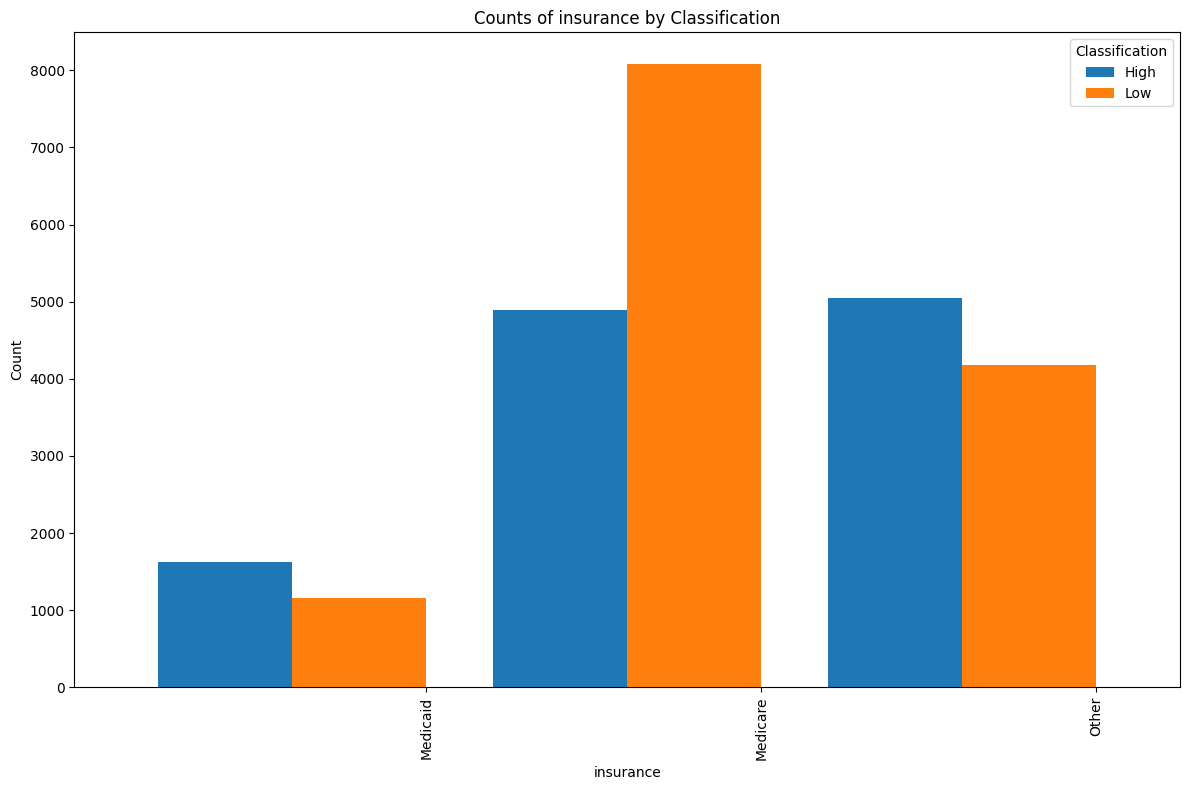

<Figure size 1200x800 with 0 Axes>

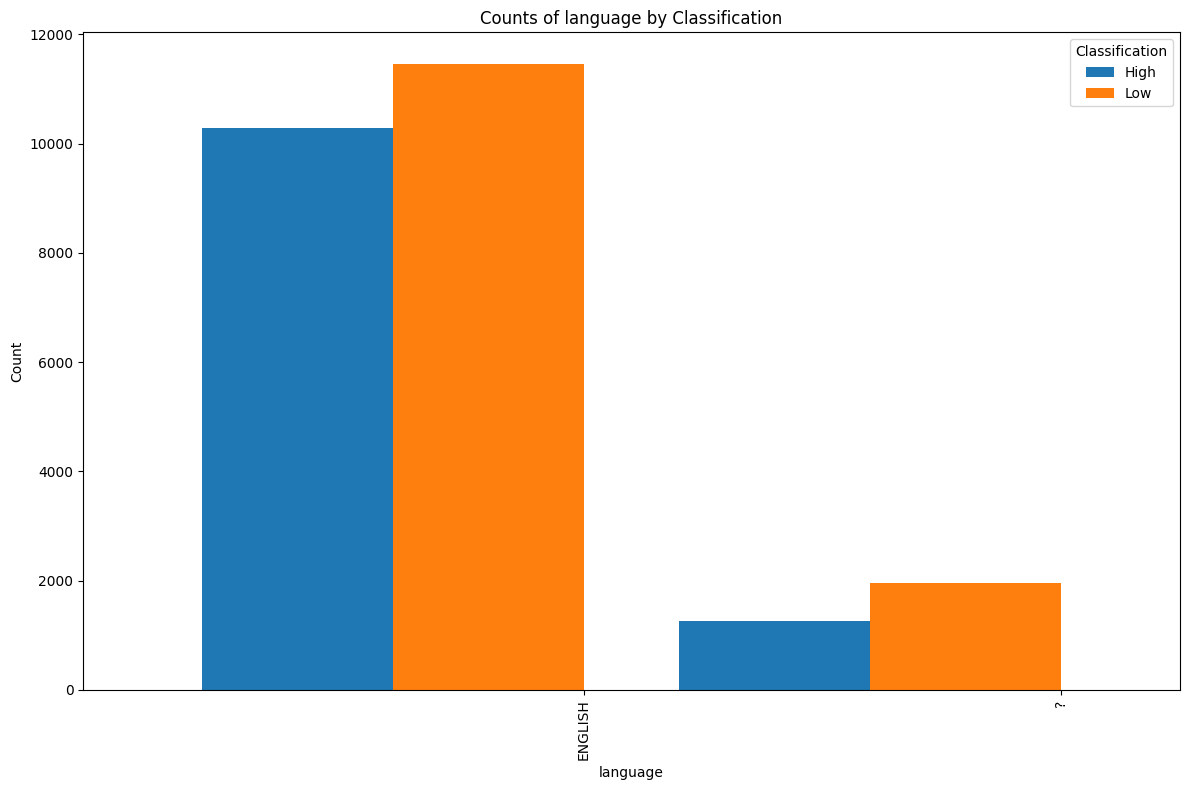

<Figure size 1200x800 with 0 Axes>

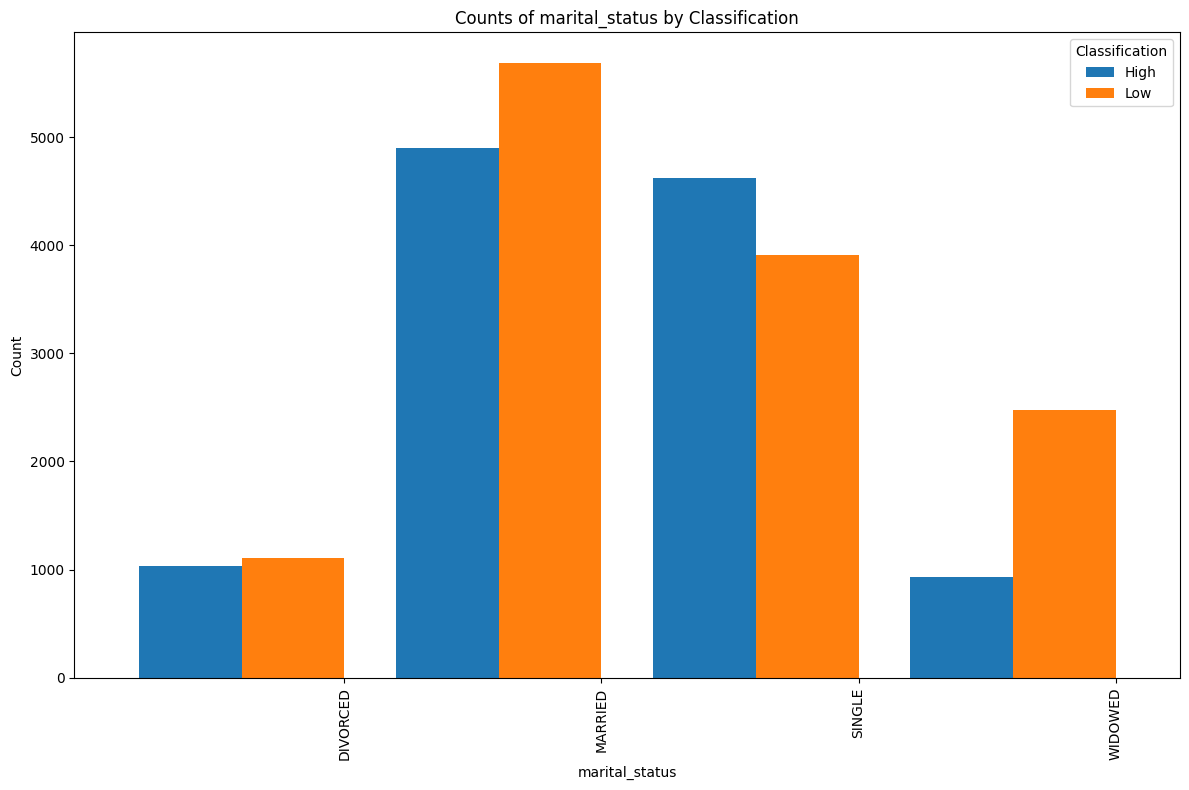

<Figure size 1200x800 with 0 Axes>

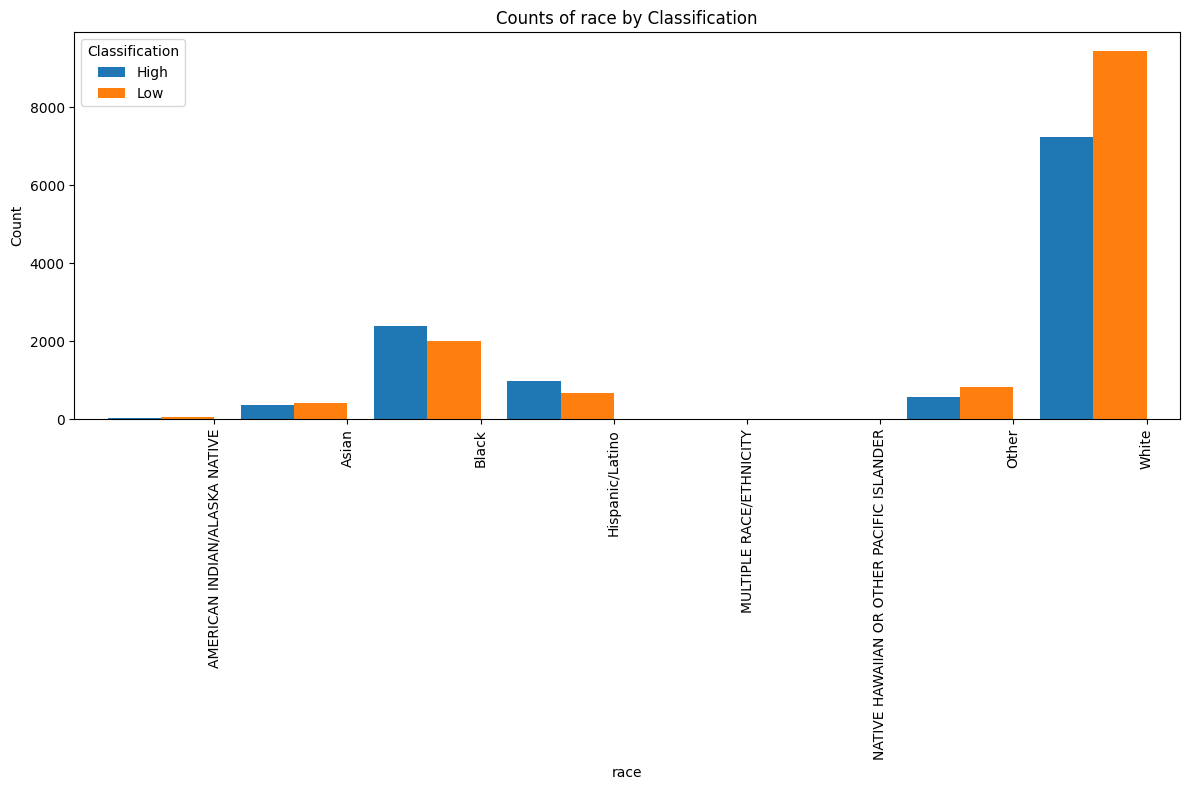

<Figure size 1200x800 with 0 Axes>

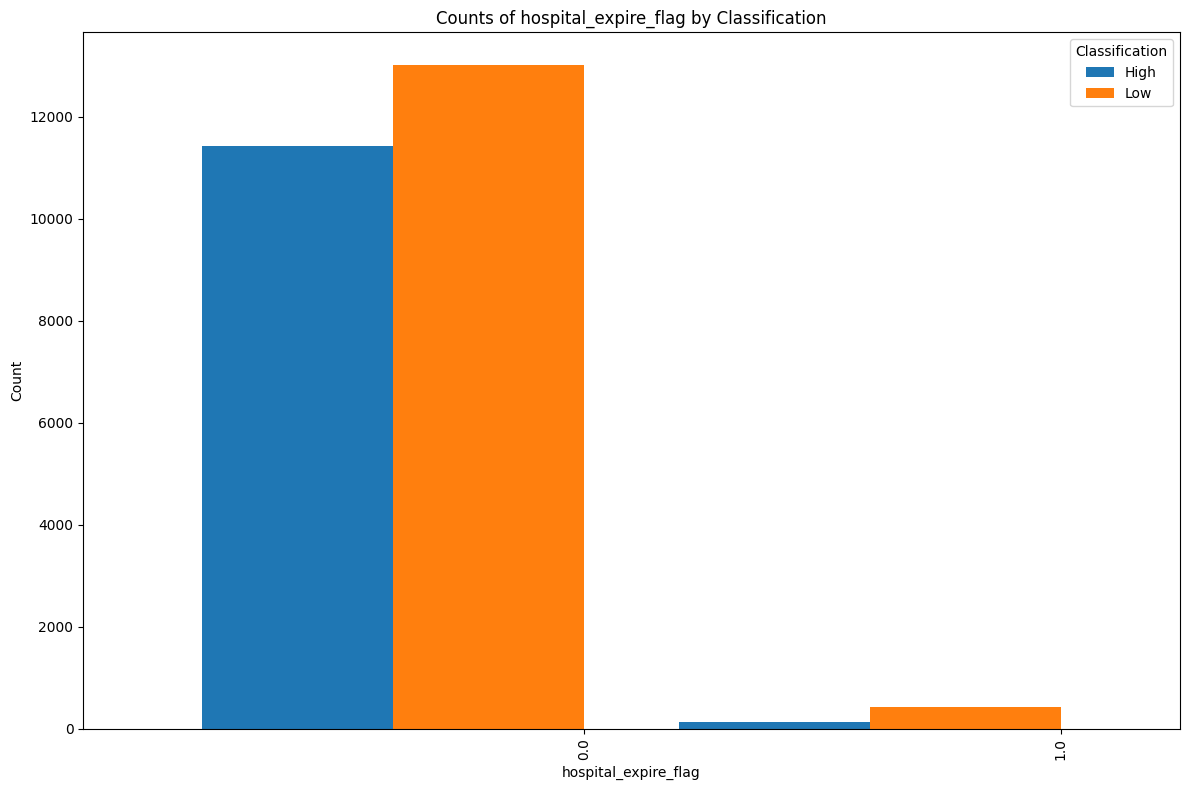

<Figure size 1200x800 with 0 Axes>

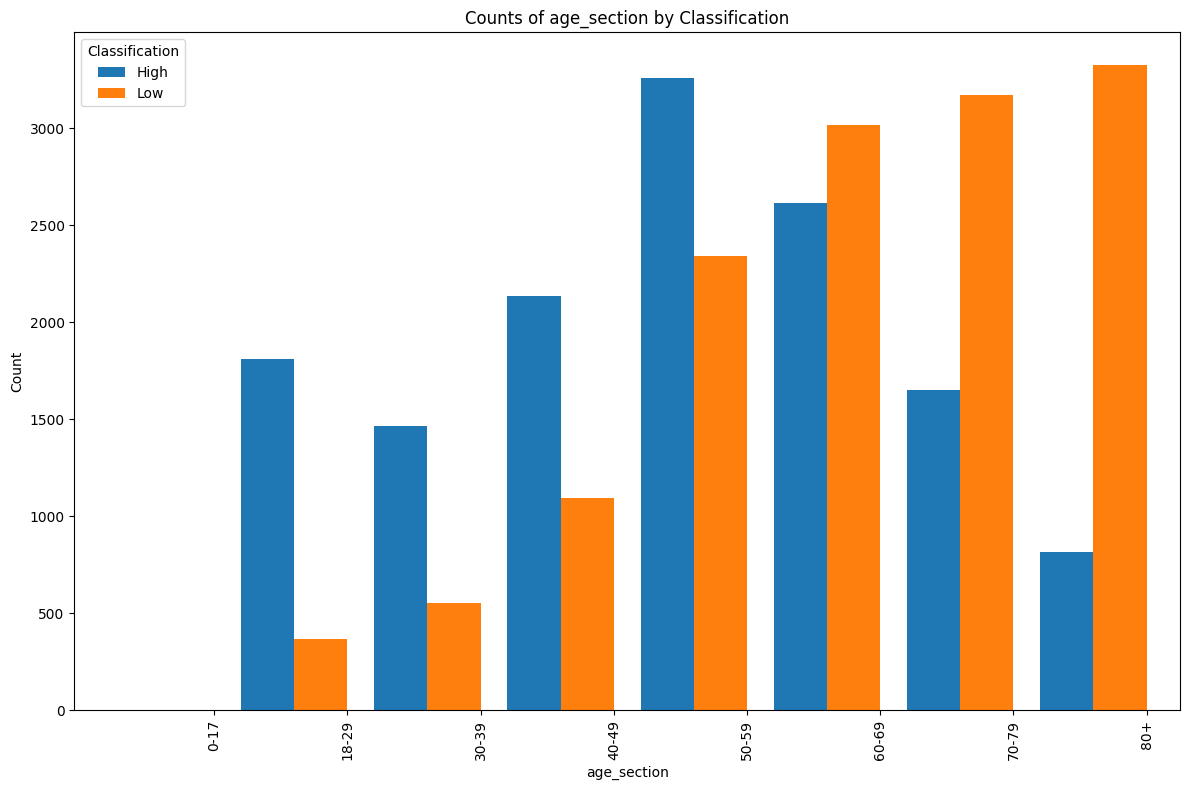

<Figure size 1200x800 with 0 Axes>

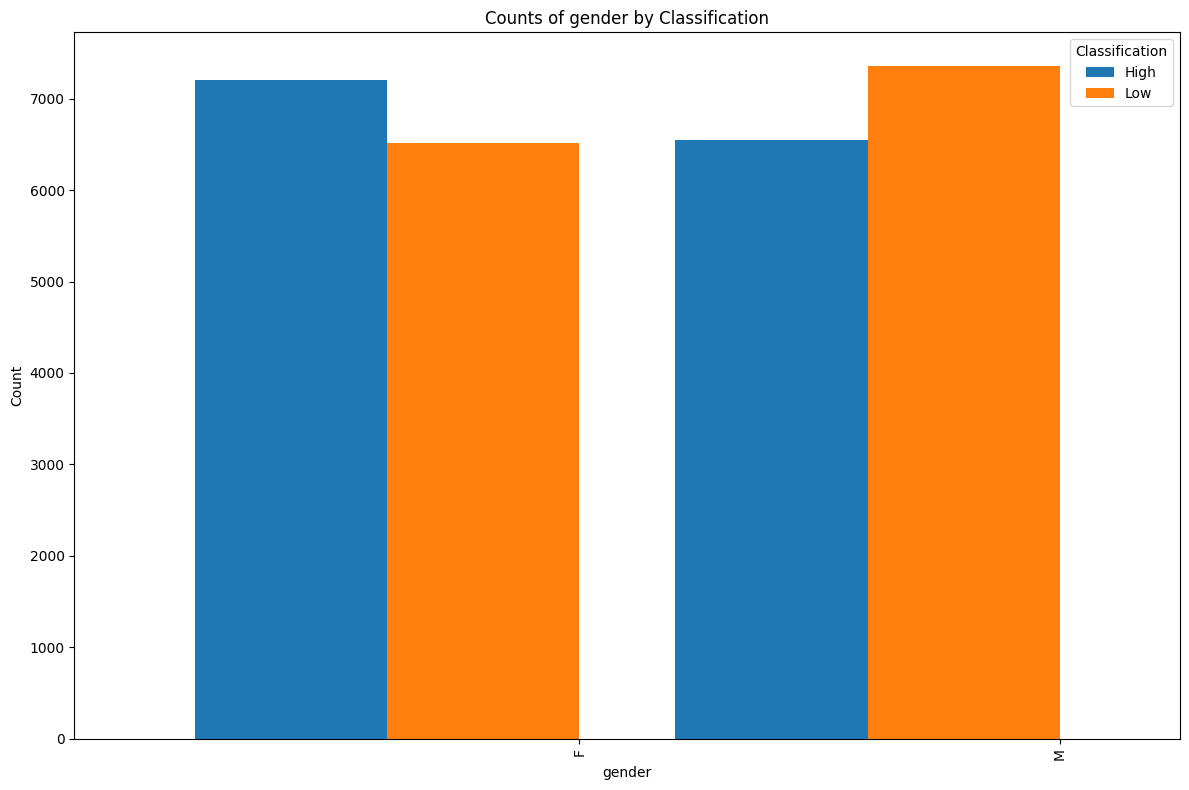

In [21]:
import matplotlib.pyplot as plt

variables = ['insurance', 'language',
             'marital_status', 'race', 'hospital_expire_flag', 'age_section', 'gender']

for var in variables:
    plt.figure(figsize=(12, 8))

    # Count occurrences for high and low classifications
    high_counts = df_high[var].value_counts()
    low_counts = df_low[var].value_counts()

    # Create a DataFrame for plotting
    counts_df = pd.DataFrame({
        'High': high_counts,
        'Low': low_counts
    }).fillna(0)  # Fill NaN values with 0

    # Plot grouped bar chart
    counts_df.plot(kind='bar', width=0.8, position=1, figsize=(12, 8))

    plt.title(f'Counts of {var} by Classification')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.legend(title='Classification')
    plt.tight_layout()

    # Save or show the plot
    plt.show()


In [22]:
df.columns

Index(['dicom', 'subject_id', 'cxr_notes', 'insurance', 'language',
       'marital_status', 'race', 'hospital_expire_flag', 'age', 'gender',
       'Label_0_Prob', 'Label_0', 'Label_1_Prob', 'Label_1', 'Label_2_Prob',
       'Label_2', 'Label_3_Prob', 'Label_3', 'Label_4_Prob', 'Label_4',
       'Label_5_Prob', 'Label_5', 'diff_0', 'diff_1', 'diff_2', 'diff_3',
       'diff_4', 'diff_5', 'avg_difference', 'classification', 'age_section'],
      dtype='object')

In [23]:
df_clusterable = df[['insurance','language','marital_status','race','hospital_expire_flag','age','gender','classification']]

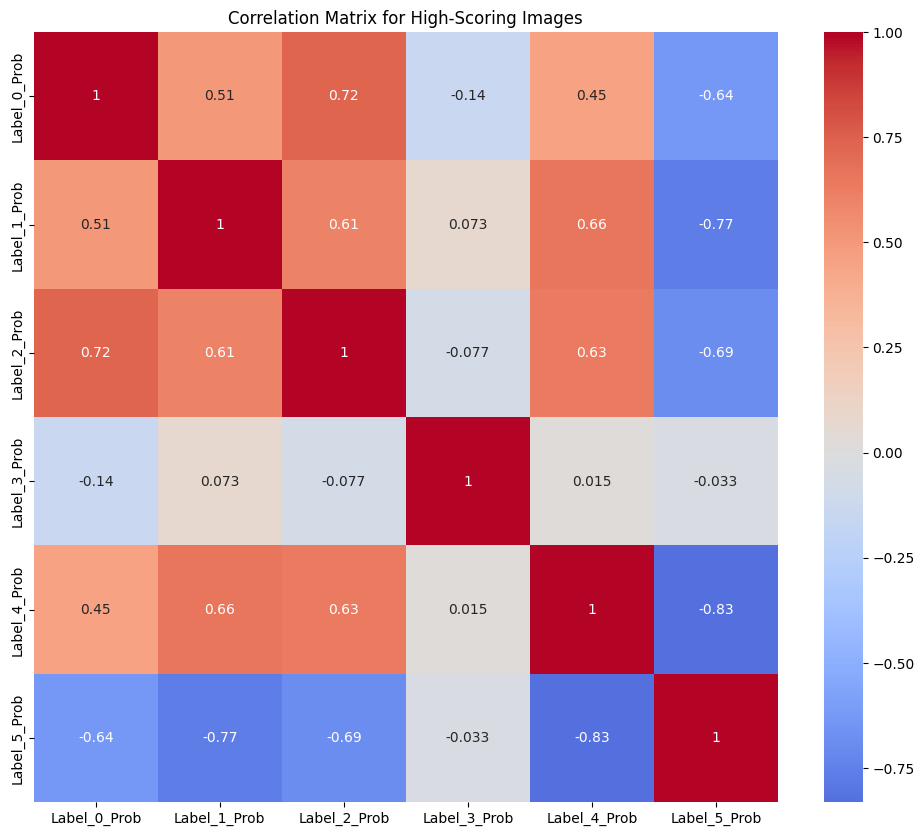

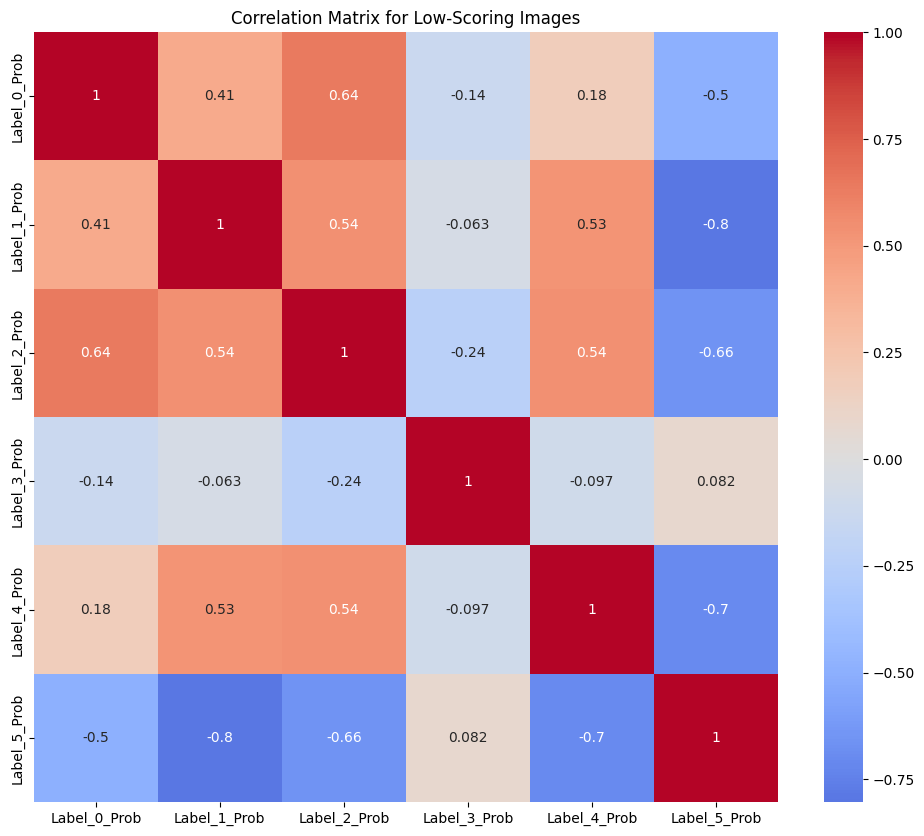

In [27]:
import seaborn as sns
# Load the full data into a DataFrame
# Correlation matrix for high-scoring images
high_scoring_df = df[df['classification'] == 'high-scoring']
low_scoring_df = df[df['classification'] == 'low-scoring']

# Compute correlations
high_scoring_corr = high_scoring_df[['Label_0_Prob', 'Label_1_Prob', 'Label_2_Prob', 'Label_3_Prob', 'Label_4_Prob', 'Label_5_Prob',]].corr(method='spearman')
low_scoring_corr = low_scoring_df[['Label_0_Prob', 'Label_1_Prob', 'Label_2_Prob', 'Label_3_Prob', 'Label_4_Prob', 'Label_5_Prob',]].corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(high_scoring_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for High-Scoring Images')
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(low_scoring_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Low-Scoring Images')
plt.show()



In [29]:
from sklearn.preprocessing import LabelEncoder
columns_to_encode = ['insurance', 'language', 'marital_status', 'race', 'gender']

# Create a dictionary to hold label encoders for each column
label_encoders = {}

# Encode string columns
for column in columns_to_encode:
    le = LabelEncoder()
    combined_df[column] = le.fit_transform(combined_df[column])
    label_encoders[column] = le

# Split the combined DataFrame back into high_scoring_df and low_scoring_df
high_scoring_df_encoded = combined_df[combined_df['classification'] == 'high-scoring']
low_scoring_df_encoded = combined_df[combined_df['classification'] == 'low-scoring']


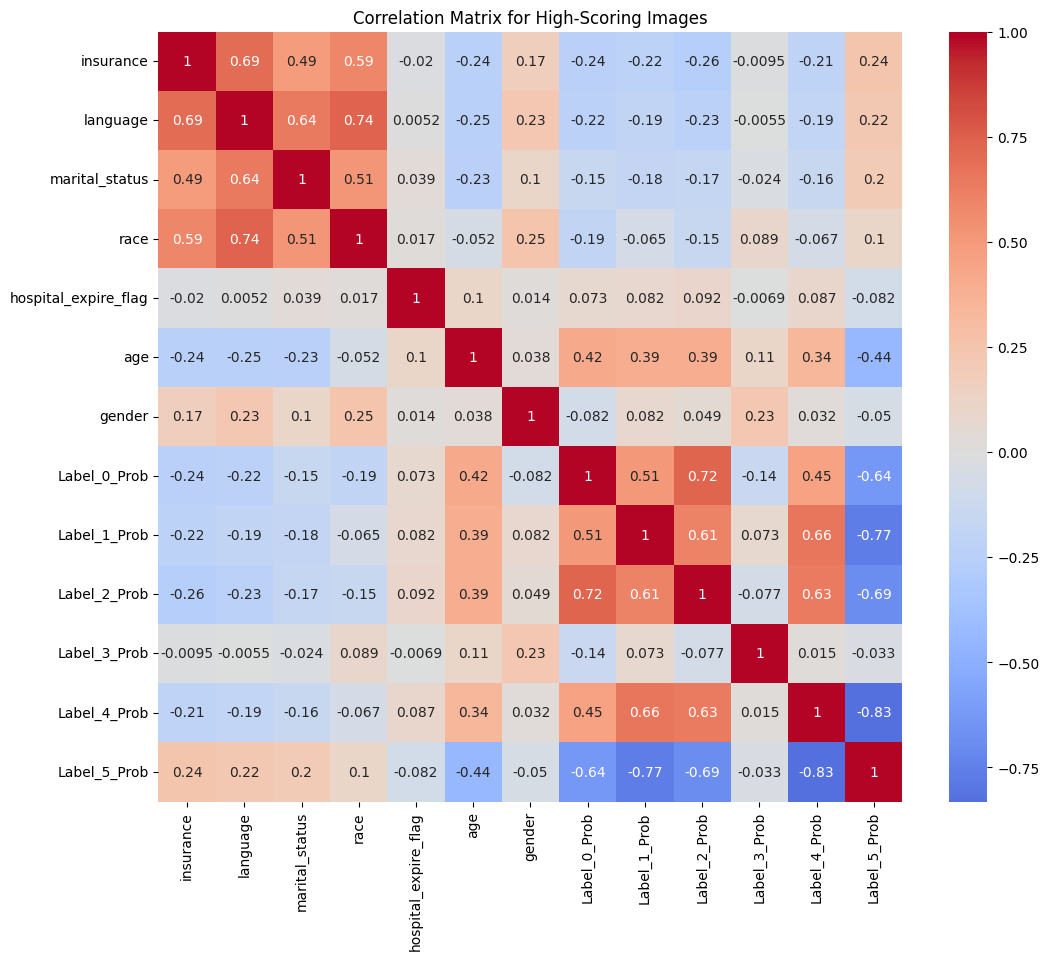

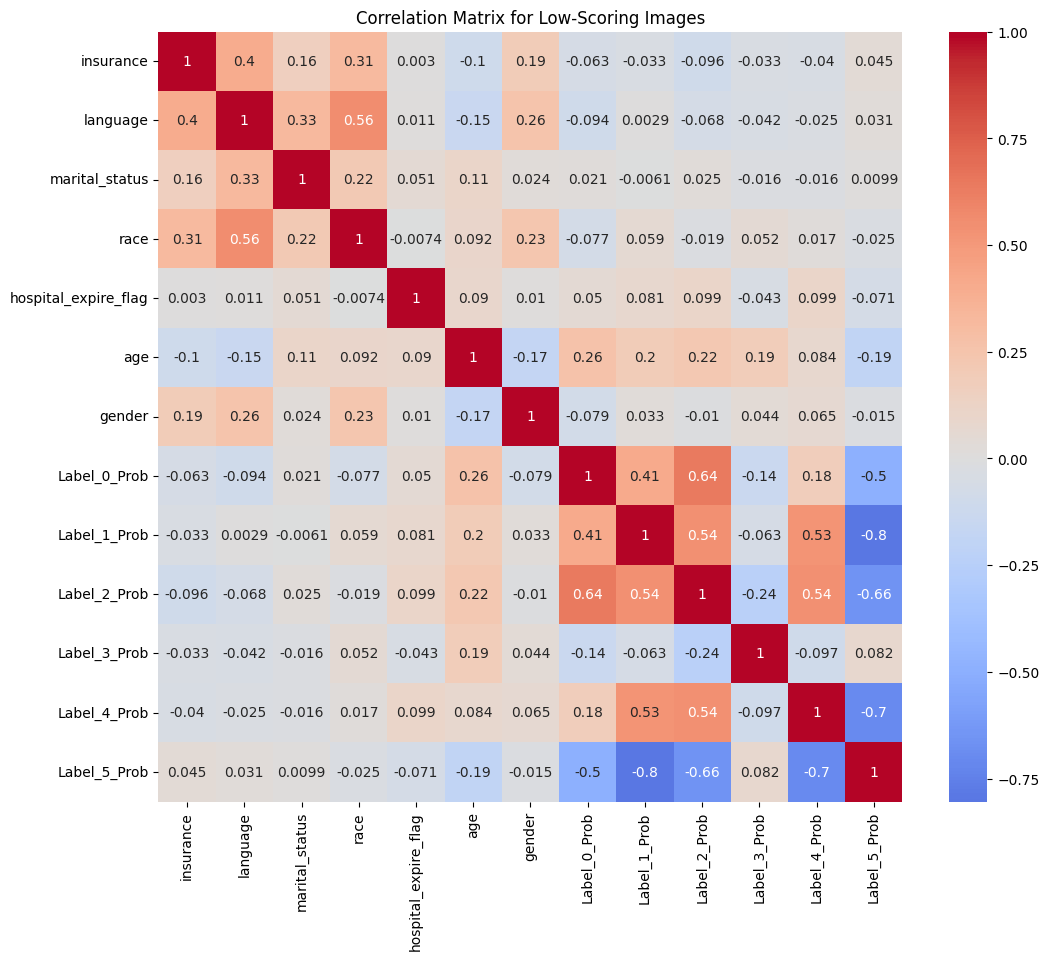

In [31]:
import seaborn as sns

# Compute correlations
high_scoring_corr = high_scoring_df_encoded[['insurance', 'language',
       'marital_status', 'race', 'hospital_expire_flag', 'age', 'gender',
       'Label_0_Prob', 'Label_1_Prob', 'Label_2_Prob', 'Label_3_Prob', 'Label_4_Prob', 'Label_5_Prob',]].corr(method='spearman')
low_scoring_corr = low_scoring_df_encoded[['insurance', 'language',
       'marital_status', 'race', 'hospital_expire_flag', 'age', 'gender',
      'Label_0_Prob', 'Label_1_Prob', 'Label_2_Prob', 'Label_3_Prob', 'Label_4_Prob', 'Label_5_Prob',]].corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(high_scoring_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for High-Scoring Images')
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(low_scoring_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Low-Scoring Images')
plt.show()



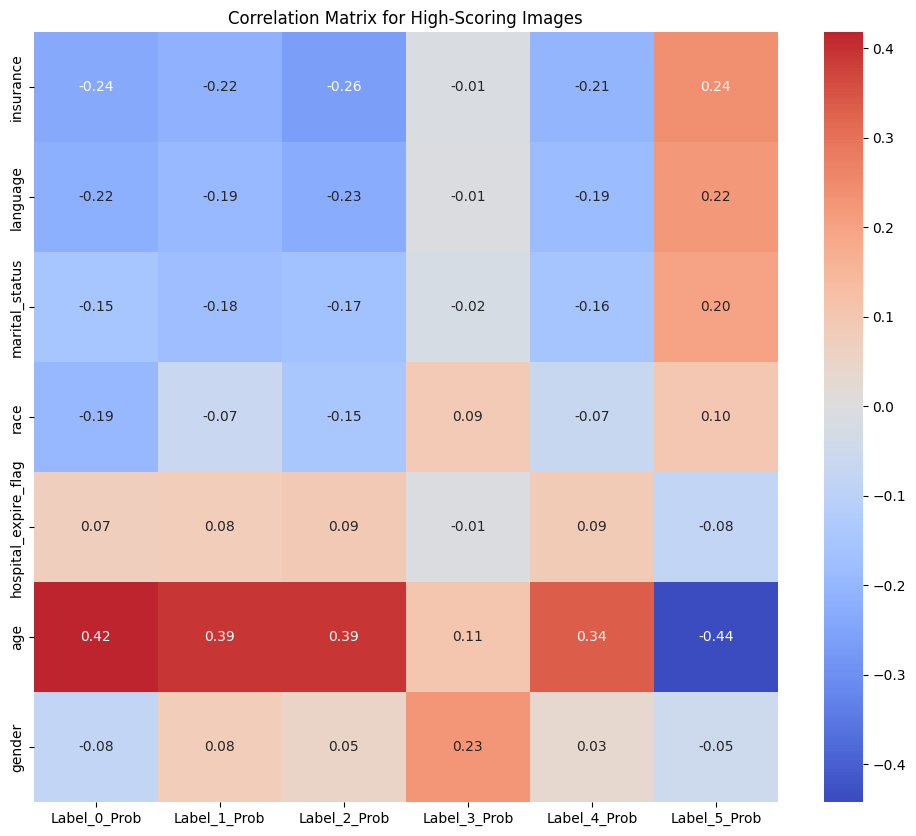

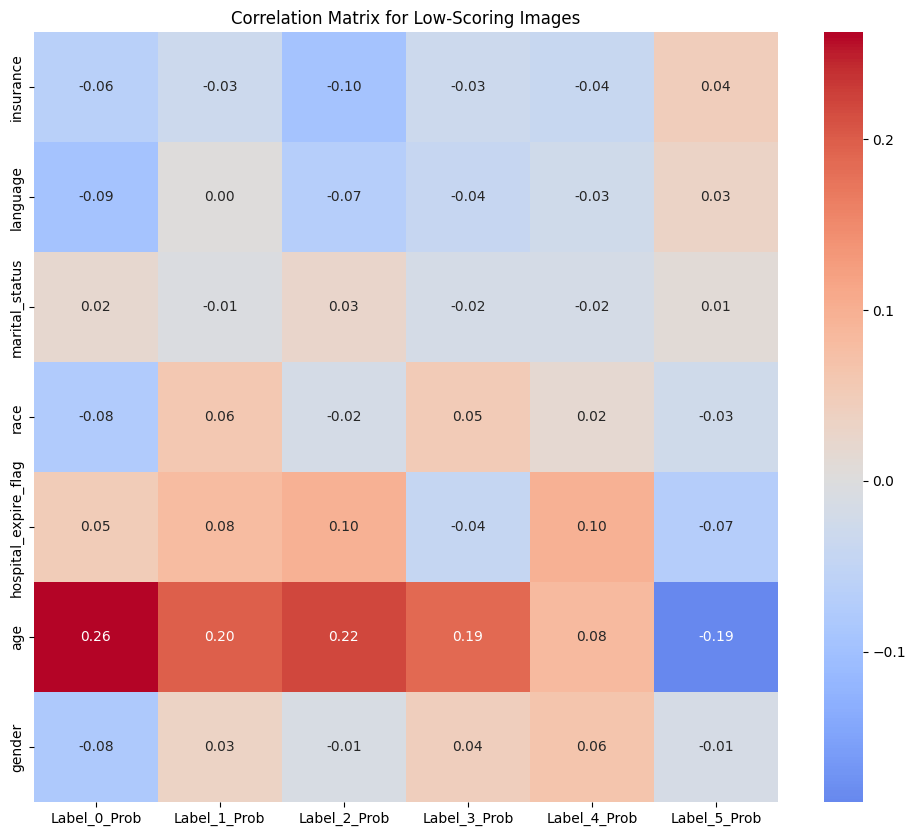

In [33]:
high_scoring_corr = high_scoring_df_encoded[['insurance', 'language',
                                             'marital_status', 'race',
                                             'hospital_expire_flag', 'age',
                                             'gender']].join(
    high_scoring_df_encoded[['Label_0_Prob', 'Label_1_Prob', 'Label_2_Prob', 'Label_3_Prob', 'Label_4_Prob', 'Label_5_Prob',]]
).corr(method='spearman')

low_scoring_corr = low_scoring_df_encoded[['insurance', 'language',
                                           'marital_status', 'race',
                                           'hospital_expire_flag', 'age',
                                           'gender']].join(
    low_scoring_df_encoded[['Label_0_Prob', 'Label_1_Prob', 'Label_2_Prob', 'Label_3_Prob', 'Label_4_Prob', 'Label_5_Prob',]]
).corr(method='spearman')

# Extract the correlation matrices for desired axes
high_scoring_corr_subset = high_scoring_corr.loc[
    ['insurance', 'language', 'marital_status', 'race', 'hospital_expire_flag', 'age', 'gender'],
    ['Label_0_Prob', 'Label_1_Prob', 'Label_2_Prob', 'Label_3_Prob', 'Label_4_Prob', 'Label_5_Prob',]
]

low_scoring_corr_subset = low_scoring_corr.loc[
    ['insurance', 'language', 'marital_status', 'race', 'hospital_expire_flag', 'age', 'gender'],
    ['Label_0_Prob', 'Label_1_Prob', 'Label_2_Prob', 'Label_3_Prob', 'Label_4_Prob', 'Label_5_Prob',]
]

# Plot the correlation matrix for high scoring
plt.figure(figsize=(12, 10))
sns.heatmap(high_scoring_corr_subset, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix for High-Scoring Images')
plt.show()

# Plot the correlation matrix for low scoring
plt.figure(figsize=(12, 10))
sns.heatmap(low_scoring_corr_subset, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix for Low-Scoring Images')
plt.show()

High-Scoring Average Error: 0.18811668567047132
Low-Scoring Average Error: 0.4111252461610891


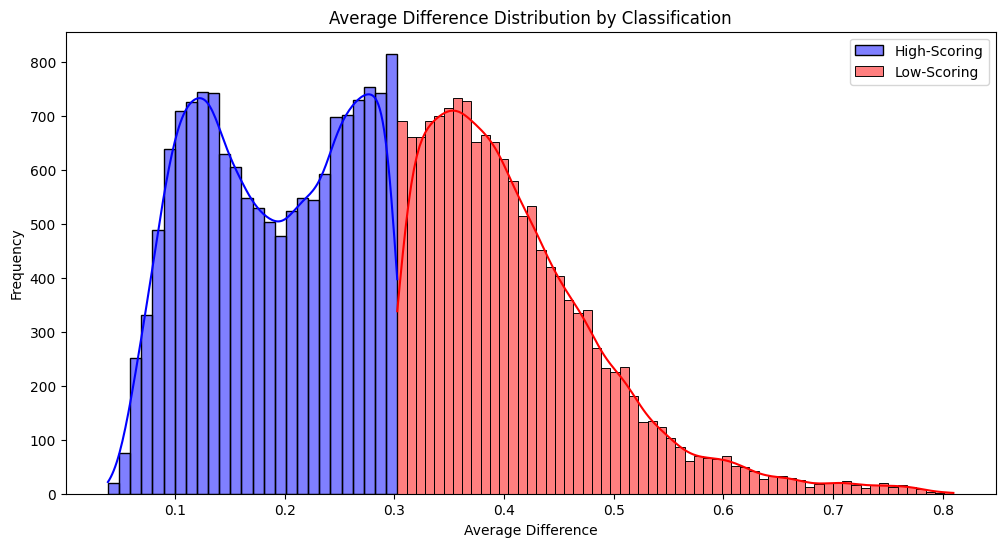

In [34]:
# Analyze differences in average prediction errors between high and low-scoring groups
high_scoring_avg_error = high_scoring_df['avg_difference'].mean()
low_scoring_avg_error = low_scoring_df['avg_difference'].mean()

print(f"High-Scoring Average Error: {high_scoring_avg_error}")
print(f"Low-Scoring Average Error: {low_scoring_avg_error}")

# Compare the distributions of average errors
plt.figure(figsize=(12, 6))
sns.histplot(high_scoring_df['avg_difference'], label='High-Scoring', color='blue', kde=True)
sns.histplot(low_scoring_df['avg_difference'], label='Low-Scoring', color='red', kde=True)
plt.xlabel('Average Difference')
plt.ylabel('Frequency')
plt.title('Average Difference Distribution by Classification')
plt.legend()
plt.show()


In [35]:
df_clusterable

,insurance,language,marital_status,race,hospital_expire_flag,age,gender,classification
0,NaN,None,None,None,NaN,NaN,None,high-scoring
1,Other,ENGLISH,MARRIED,White,0.0,46.0,M,low-scoring
2,Medicare,?,DIVORCED,White,0.0,56.0,M,low-scoring
3,Other,ENGLISH,MARRIED,White,0.0,49.0,M,high-scoring
4,Other,ENGLISH,MARRIED,White,0.0,47.0,M,high-scoring
...,...,...,...,...,...,...,...,...
29322,Medicare,ENGLISH,None,Other,0.0,62.0,F,low-scoring
29323,Other,ENGLISH,WIDOWED,White,0.0,88.0,F,low-scoring
29324,NaN,None,None,None,NaN,53.0,F,high-scoring
29325,NaN,None,None,None,NaN,25.0,F,high-scoring


In [36]:
df

,dicom,subject_id,cxr_notes,insurance,language,marital_status,race,hospital_expire_flag,age,gender,...,Label_5,diff_0,diff_1,diff_2,diff_3,diff_4,diff_5,avg_difference,classification,age_section
0,00009bca-0893e5e4-c1296676-181f5233-25dfa9a3,15342241,FINAL REPORT\...,3,2,4,8,NaN,NaN,2,...,1,0.010278,0.007426,0.007360,0.611739,0.180992,0.095570,0.152228,high-scoring,NaN
1,00039aac-942aea85-a4f7cd1c-faed6733-c8701b02,10900906,FINAL REPORT\...,2,1,1,7,0.0,46.0,1,...,0,0.222074,0.005796,0.113619,0.625526,0.685194,0.753666,0.400979,low-scoring,40-49
2,00071f00-c64a427a-12c137e5-d1c37dce-d1a7acce,15952397,FINAL REPORT\...,1,0,0,7,0.0,56.0,1,...,1,0.023111,0.075882,0.057028,0.673343,0.799027,0.416866,0.340876,low-scoring,50-59
3,0008e0fa-0eb60c98-ee781d21-ea13a025-11180313,10614767,FINAL REPORT\...,2,1,1,7,0.0,49.0,1,...,1,0.021235,0.006293,0.022956,0.647001,0.053372,0.047185,0.133007,high-scoring,40-49
4,000a0e37-937e40b9-b1318438-ba4e64cd-fb7f8641,10779064,WET READ: ___ ___ 5:56 PM\n Persistent basil...,2,1,1,7,0.0,47.0,1,...,0,0.567185,0.008330,0.405909,0.317641,0.336714,0.030948,0.277788,high-scoring,40-49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29322,fff92aa6-137b75ae-a7422231-460483f7-391d45eb,14235312,FINAL REPORT\...,1,1,4,6,0.0,62.0,0,...,0,0.135460,0.865335,0.367631,0.700562,0.383118,0.532702,0.497468,low-scoring,60-69
29323,fffb28b4-1baa9271-538012ae-89dcdaab-a2d84281,16245569,FINAL REPORT\...,2,1,3,7,0.0,88.0,0,...,0,0.648430,0.064056,0.413291,0.759276,0.432697,0.024186,0.390323,low-scoring,80+
29324,fffd87ef-96f6c135-5657c776-7038de80-ae5ac633,18709910,FINAL REPORT\...,3,2,4,8,NaN,53.0,0,...,1,0.027634,0.002379,0.009191,0.453353,0.077326,0.032590,0.100412,high-scoring,50-59
29325,fffe4f4e-0d083b59-6d04c00d-07aabeda-9997fcfd,12224571,FINAL REPORT\...,3,2,4,8,NaN,25.0,0,...,1,0.022297,0.003887,0.004094,0.316558,0.050426,0.087221,0.080747,high-scoring,18-29


In [37]:
threshold

0.30269220483333337

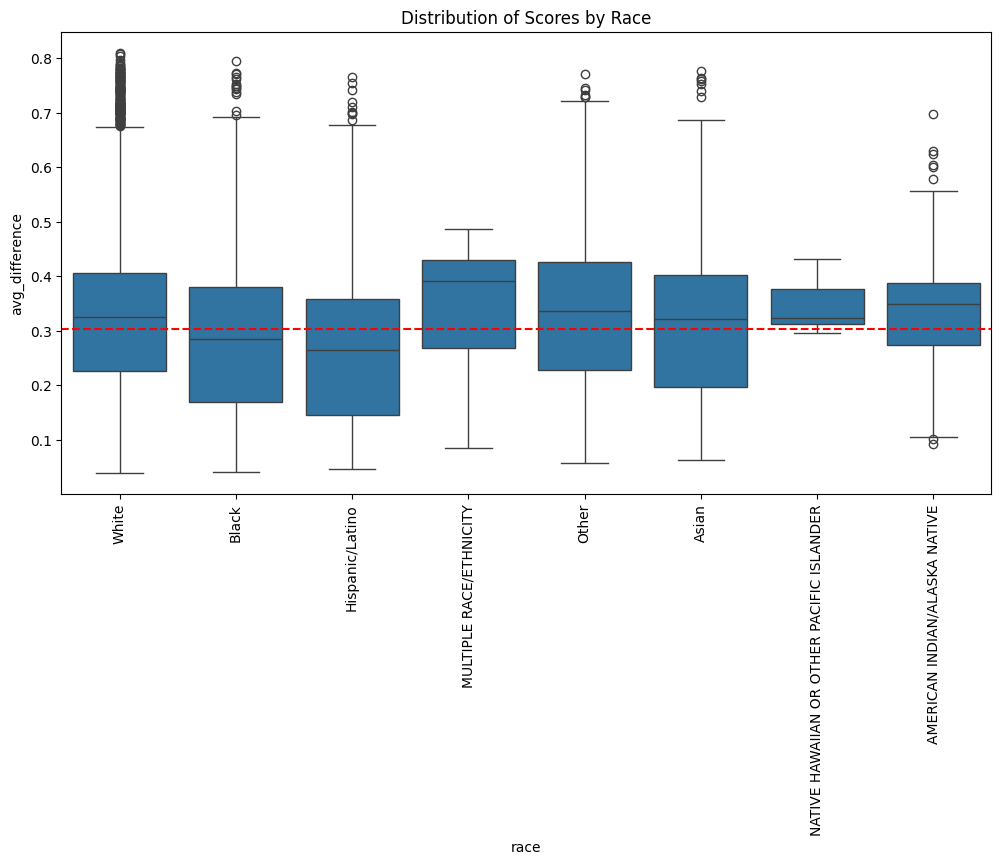

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
sns.boxplot(x='race', y='avg_difference', data=df)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
plt.title('Distribution of Scores by Race')
plt.xticks(rotation=90)
plt.show()


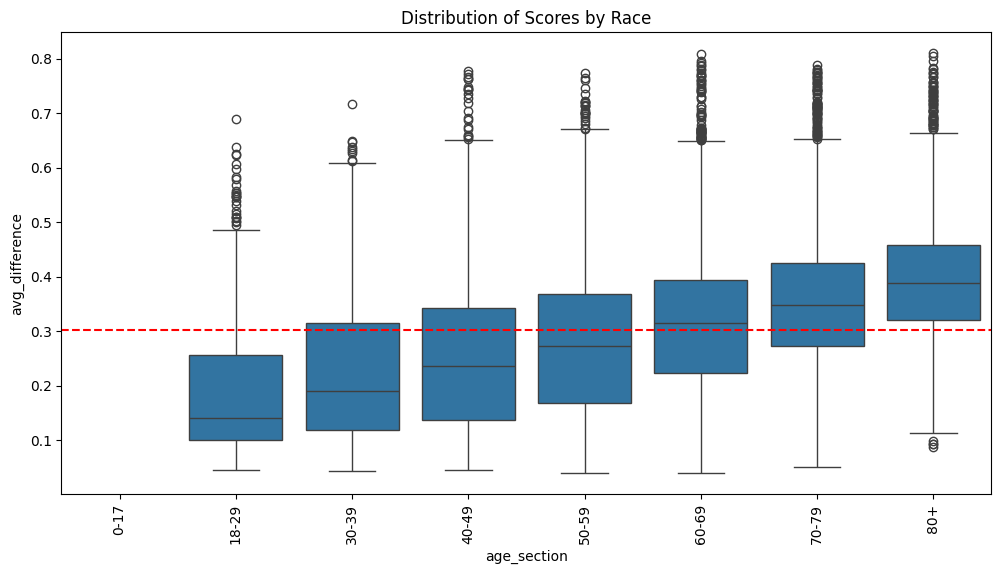

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
sns.boxplot(x='age_section', y='avg_difference', data=df)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
plt.title('Distribution of Scores by Race')
plt.xticks(rotation=90)
plt.show()


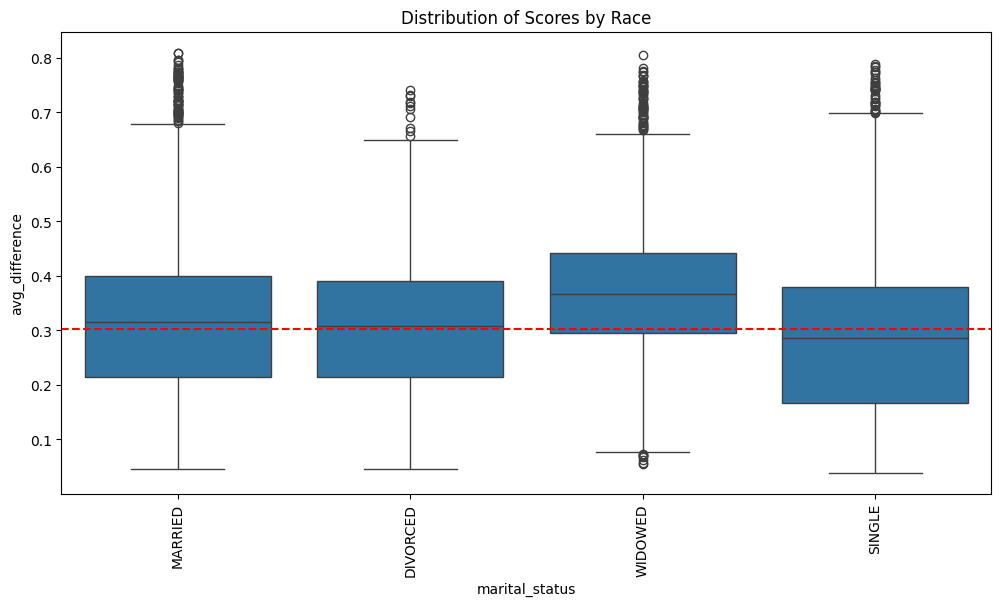

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
sns.boxplot(x='marital_status', y='avg_difference', data=df)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
plt.title('Distribution of Scores by Race')
plt.xticks(rotation=90)
plt.show()


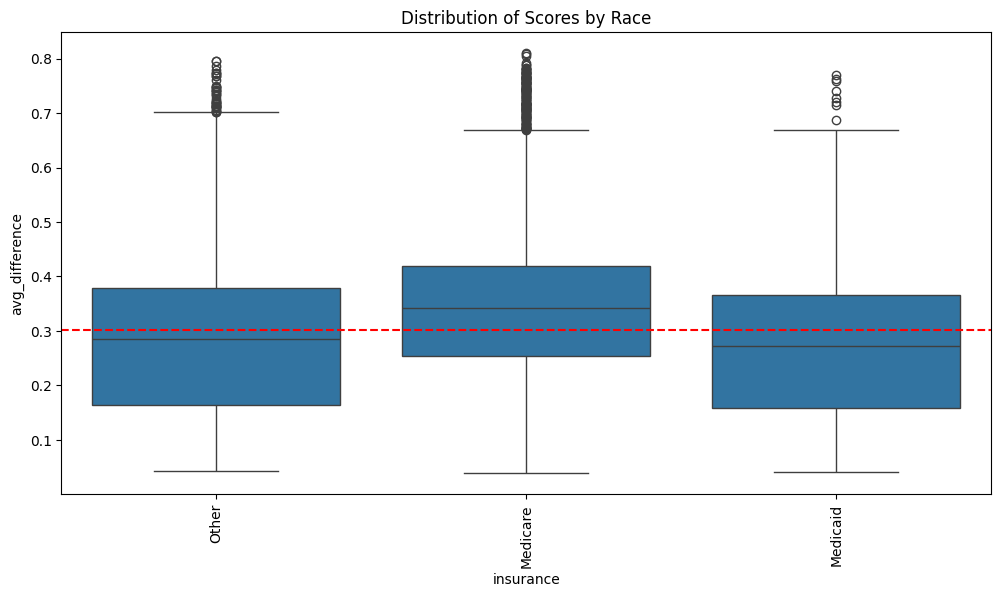

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
sns.boxplot(x='insurance', y='avg_difference', data=df)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
plt.title('Distribution of Scores by Race')
plt.xticks(rotation=90)
plt.show()


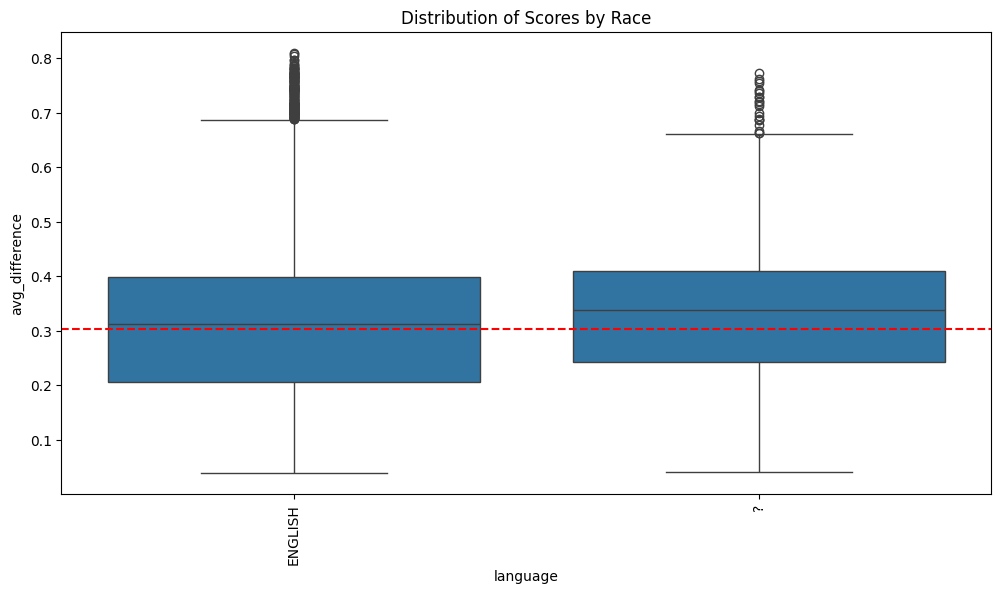

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
sns.boxplot(x='language', y='avg_difference', data=df)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
plt.title('Distribution of Scores by Race')
plt.xticks(rotation=90)
plt.show()


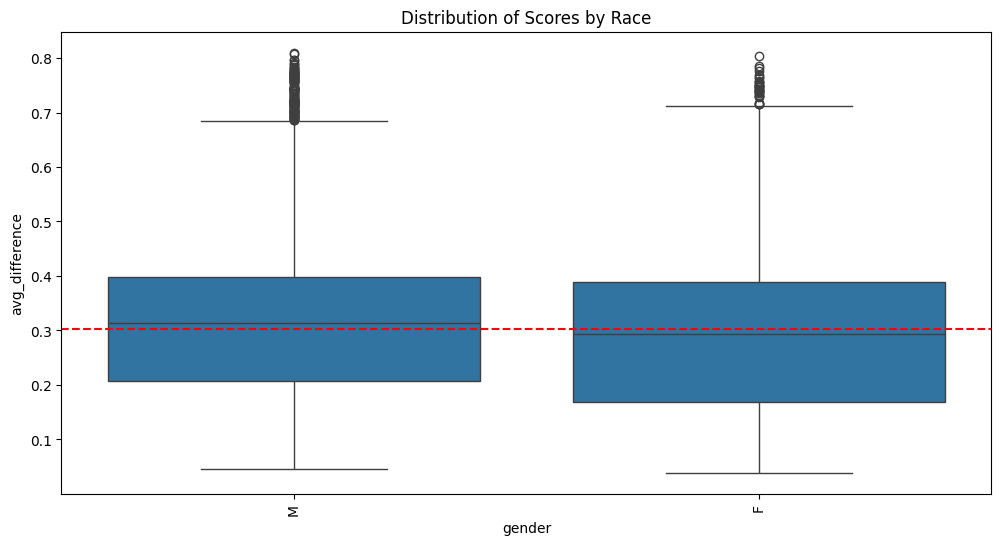

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
sns.boxplot(x='gender', y='avg_difference', data=df)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
plt.title('Distribution of Scores by Race')
plt.xticks(rotation=90)
plt.show()
